[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# Zero-Shot Object Detection and Segmentation with YOLOE

---

[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/THU-MIG/yoloe)
[![arXiv](https://img.shields.io/badge/arXiv-2503.07465-b31b1b.svg)](https://arxiv.org/abs/2503.07465)
[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/zero-shot-object-detection-and-segmentation-with-yoloe.ipynb)

Object detection and segmentation are often constrained by predefined categories or heavy open-set methods. YOLOE consolidates detection and segmentation for text, visual, or no prompts in one efficient model. It re-parameterizes textual embeddings, employs a semantic-activated visual prompt encoder, and leverages a built-in vocabulary for prompt-free detection. Extensive tests show real-time performance, strong zero-shot transferability, and lower training cost. On LVIS, YOLOE outperforms YOLO-Worldv2 with 3× less training cost and faster inference. On COCO, YOLOE exceeds closed-set YOLOv8 with nearly 4× fewer training hours.

![YOLOE architecture](https://storage.googleapis.com/com-roboflow-marketing/notebooks/examples/yoloe-2.png)

![YOLOE example results](https://storage.googleapis.com/com-roboflow-marketing/notebooks/examples/yoloe-1.png)

## Environment setup

### Configure your API keys

To download YOLOE weights, you need to provide your HuggingFace Token. Follow these steps:

- Open your [`HuggingFace Settings`](https://huggingface.co/settings) page. Click `Access Tokens` then `New Token` to generate new token.
- In Colab, go to the left pane and click on `Secrets` (🔑). tore HuggingFace Access Token under the name `HF_TOKEN`.

### Check GPU availability

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `T4 GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Mon Mar 17 13:33:38 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   53C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Install dependencies

In [2]:
!pip install -q "git+https://github.com/THU-MIG/yoloe.git#subdirectory=third_party/CLIP"
!pip install -q "git+https://github.com/THU-MIG/yoloe.git#subdirectory=third_party/ml-mobileclip"
!pip install -q "git+https://github.com/THU-MIG/yoloe.git#subdirectory=third_party/lvis-api"
!pip install -q "git+https://github.com/THU-MIG/yoloe.git"

!pip install -q supervision jupyter_bbox_widget

!wget -q https://docs-assets.developer.apple.com/ml-research/datasets/mobileclip/mobileclip_blt.pt

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 86.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 69.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 72.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

### Pull weights

In [3]:
from huggingface_hub import hf_hub_download

path = hf_hub_download(repo_id="jameslahm/yoloe", filename="yoloe-v8l-seg.pt", local_dir='.')
path = hf_hub_download(repo_id="jameslahm/yoloe", filename="yoloe-v8l-seg-pf.pt", local_dir='.')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


yoloe-v8l-seg.pt:   0%|          | 0.00/107M [00:00<?, ?B/s]

yoloe-v8l-seg-pf.pt:   0%|          | 0.00/103M [00:00<?, ?B/s]

### Download example data

If you want to run the cookbook using your own file as input, simply upload video to Google Colab and replace `SOURCE_IMAGE_PATH` and `SOURCE_VIDEO_PATH` with the path to your file.

In [ ]:
!wget -q https://media.roboflow.com/notebooks/examples/dog.jpeg
!wget -q https://media.roboflow.com/notebooks/examples/dog-2.jpeg
!wget -q https://media.roboflow.com/notebooks/examples/dog-3.jpeg
!wget -q https://media.roboflow.com/notebooks/examples/dog-4.jpeg
!wget -q https://media.roboflow.com/notebooks/examples/dog-5.jpeg
!wget -q https://media.roboflow.com/notebooks/examples/dog-6.jpeg
!wget -q https://media.roboflow.com/notebooks/examples/dog-7.jpeg
!wget -q https://media.roboflow.com/notebooks/examples/dog-8.jpeg

!wget -q https://media.roboflow.com/supervision/video-examples/croissant-1280x720.mp4
!wget -q https://media.roboflow.com/supervision/video-examples/suitcases-1280x720.mp4
!wget -q https://media.roboflow.com/supervision/video-examples/factory-1280x720.mp4

## Text prompt for image processiong

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Build text model mobileclip:blt


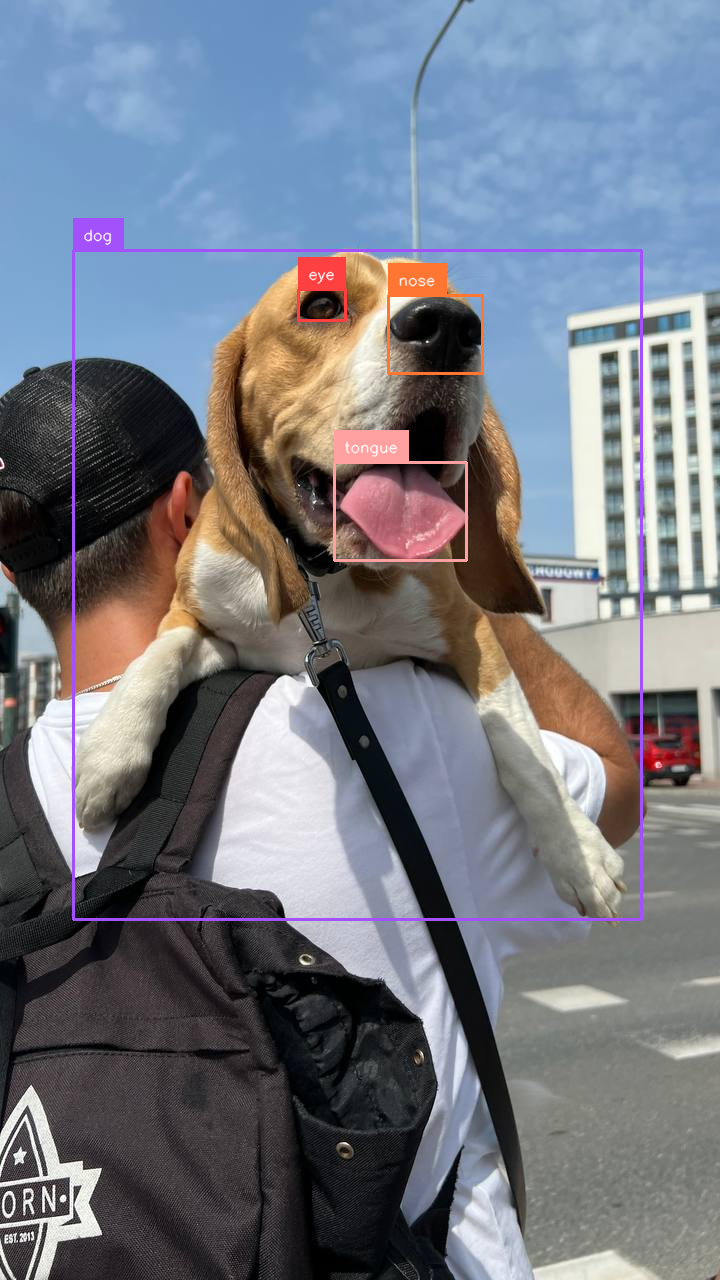

In [ ]:
import supervision as sv
from ultralytics import YOLOE
from PIL import Image

IMAGE_PATH = "dog.jpeg"
NAMES = ["dog", "eye", "tongue", "nose", "ear"]

model = YOLOE("yoloe-v8l-seg.pt").cuda()
model.set_classes(NAMES, model.get_text_pe(NAMES))

image = Image.open(IMAGE_PATH)
results = model.predict(image, conf=0.1, verbose=False)

detections = sv.Detections.from_ultralytics(results[0])

annotated_image = image.copy()
annotated_image = sv.BoxAnnotator().annotate(scene=annotated_image, detections=detections)
annotated_image = sv.LabelAnnotator().annotate(scene=annotated_image, detections=detections)

annotated_image

Build text model mobileclip:blt


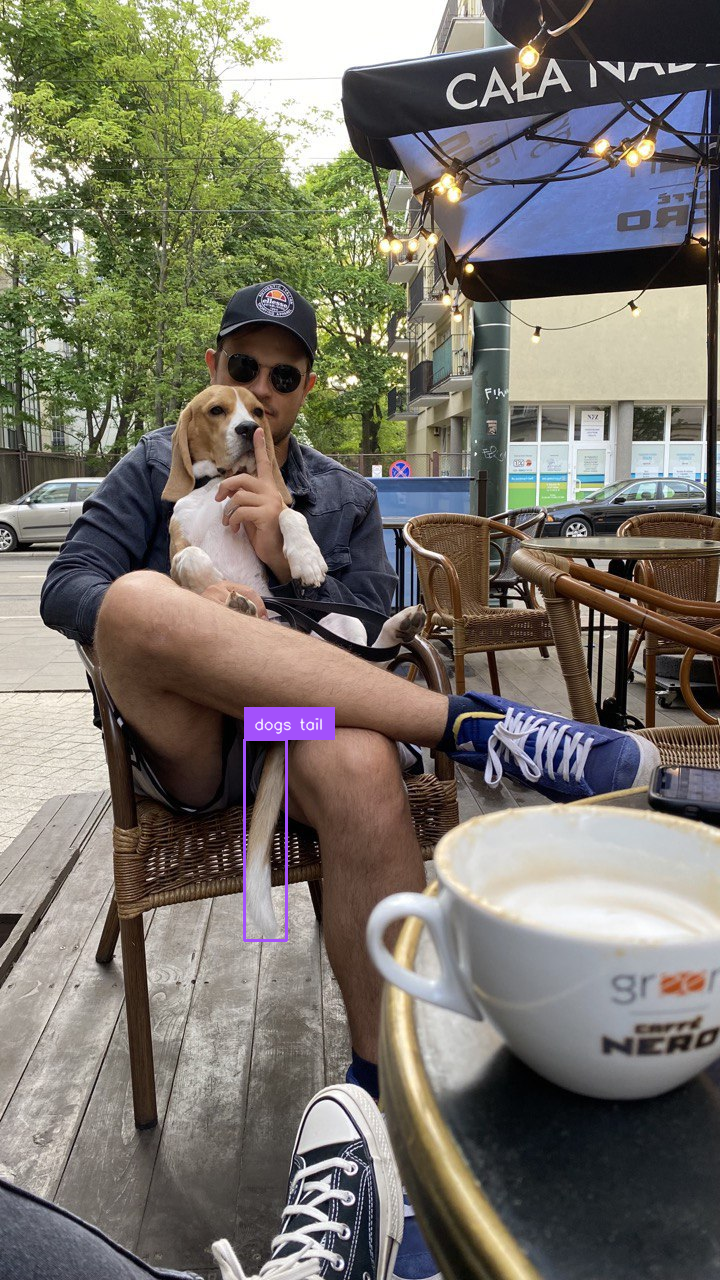

In [ ]:
import supervision as sv
from ultralytics import YOLOE
from PIL import Image

IMAGE_PATH = "dog-3.jpeg"
NAMES = ["dogs tail"]

model = YOLOE("yoloe-v8l-seg.pt").cuda()
model.set_classes(NAMES, model.get_text_pe(NAMES))

image = Image.open(IMAGE_PATH)
results = model.predict(image, conf=0.1, verbose=False)
detections = sv.Detections.from_ultralytics(results[0])

annotated_image = image.copy()
annotated_image = sv.BoxAnnotator().annotate(scene=annotated_image, detections=detections)
annotated_image = sv.LabelAnnotator().annotate(scene=annotated_image, detections=detections)

annotated_image

## Visual prompt for image processiong

In [ ]:
import base64

def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

**NOTE:** Execute cell below and use your mouse to **draw bounding box** on the image 👇

In [ ]:
IS_COLAB = True
SOURCE_IMAGE_PATH = "dog-3.jpeg"
TARGET_IMAGE_PATH = "dog-8.jpeg"
NAMES = ['cap', 'sunglasses', 'dog']

if IS_COLAB:
    from google.colab import output
    output.enable_custom_widget_manager()

from jupyter_bbox_widget import BBoxWidget

widget = BBoxWidget(classes=NAMES)
widget.image = encode_image(IMAGE_PATH)
widget

BBoxWidget(classes=['cap', 'sunglasses', 'dog'], colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'…

In [ ]:
widget.bboxes

[{'x': 211, 'y': 274, 'width': 115, 'height': 85, 'label': 'cap'},
 {'x': 218, 'y': 351, 'width': 94, 'height': 47, 'label': 'sunglasses'},
 {'x': 161, 'y': 380, 'width': 272, 'height': 570, 'label': 'dog'}]

**NOTE:** `YOLOEVPSegPredictor` takes `np.ndarray` box prompt in `[x_min, y_min, x_max, y_max]` format.

In [ ]:
import numpy as np

default_box = [
    {'x': 216, 'y': 275, 'width': 108, 'height': 83, 'label': 'cap'},
    {'x': 225, 'y': 351, 'width': 84, 'height': 51, 'label': 'sunglasses'},
    {'x': 160, 'y': 383, 'width': 270, 'height': 555, 'label': 'dog'}
]

boxes = widget.bboxes if widget.bboxes else default_box
bboxes = np.array([
    [
        box['x'],
        box['y'],
        box['x'] + box['width'],
        box['y'] + box['height']
    ] for box in boxes
], dtype=np.float64)

cls = np.array([NAMES.index(box['label']) for box in boxes], dtype=np.int32)


0: 640x640 1 object0, 1 object1, 3 object2s, 190.1ms
Speed: 29.3ms preprocess, 190.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 cap, 1 dog, 46.5ms
Speed: 3.0ms preprocess, 46.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


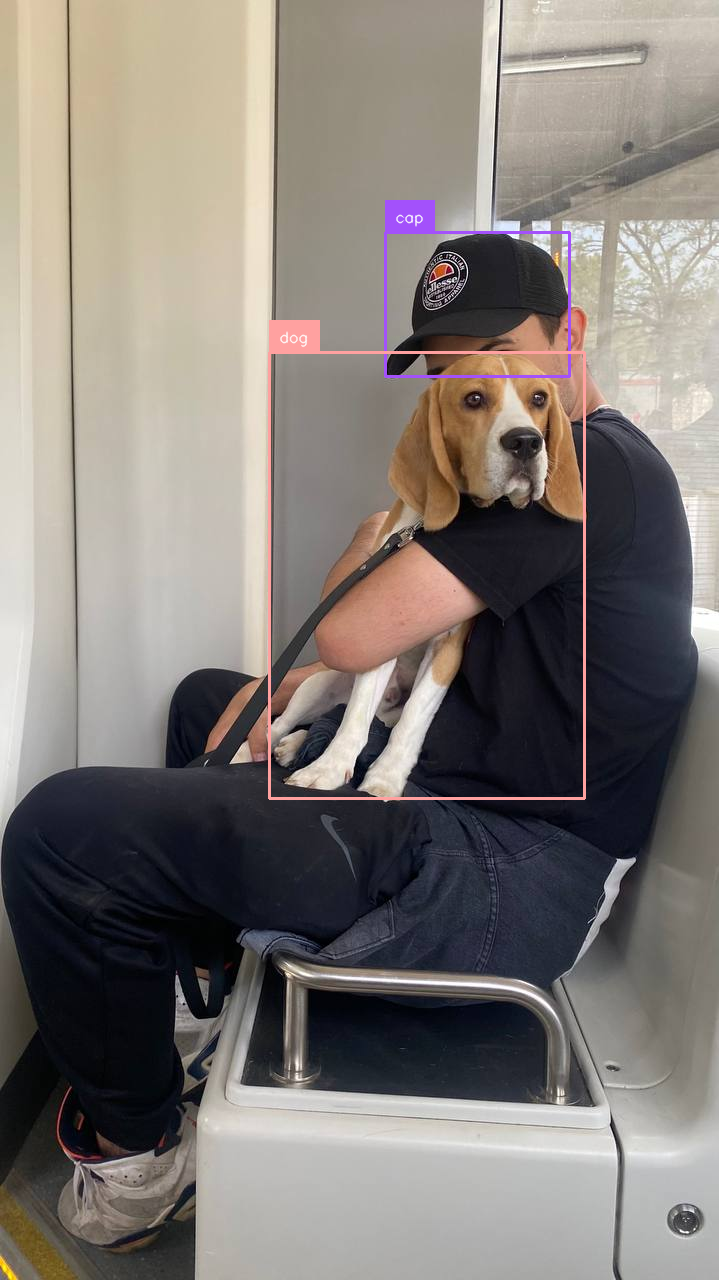

In [ ]:
from ultralytics import YOLOE
from ultralytics.models.yolo.yoloe.predict_vp import YOLOEVPSegPredictor

model = YOLOE("yoloe-v8l-seg.pt").cuda()
prompts = dict(bboxes=bboxes, cls=cls)

source_image = Image.open(SOURCE_IMAGE_PATH)
target_image = Image.open(TARGET_IMAGE_PATH)

model.predict(source_image, prompts=prompts, predictor=YOLOEVPSegPredictor, return_vpe=True)
model.set_classes(NAMES, model.predictor.vpe)
model.predictor = None

results = model.predict(target_image)
detections = sv.Detections.from_ultralytics(results[0])

annotated_image = target_image.copy()
annotated_image = sv.BoxAnnotator().annotate(scene=annotated_image, detections=detections)
annotated_image = sv.LabelAnnotator().annotate(scene=annotated_image, detections=detections)

annotated_image

## Script to rotate video

In [ ]:
import cv2

input_video_path = 'IMG_2041.mov'
output_video_path = 'IMG_2041_rotated.mp4'

# Open input video
cap = cv2.VideoCapture(input_video_path)
fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Output video writer (note width and height swapped due to rotation)
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_video_path, fourcc, fps, (height, width))

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Rotate 90º clockwise
    rotated_frame = cv2.rotate(frame, cv2.ROTATE_90_CLOCKWISE)

    # Write rotated frame
    out.write(rotated_frame)

# Release resources
cap.release()
out.release()

print(f'Rotated video saved as {output_video_path}')

## Text prompt for video processiong

In [4]:
import supervision as sv
from ultralytics import YOLOE
from PIL import Image
from tqdm import tqdm

SOURCE_VIDEO_PATH = "IMG_2041.MOV"
TARGET_VIDEO_PATH = "paintings-result.mp4"
NAMES = ["suitcase"]

model = YOLOE("yoloe-v8l-seg.pt").cuda()
model.set_classes(NAMES, model.get_text_pe(NAMES))

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

# visualize video frames sample in notebook
frames = []
frame_interval = 10

with sv.VideoSink(TARGET_VIDEO_PATH, video_info) as sink:
    for index, frame in enumerate(tqdm(frame_generator)):
        results = model.predict(frame, conf=0.1, verbose=False)
        detections = sv.Detections.from_ultralytics(results[0])

        annotated_image = frame.copy()
        annotated_image = sv.ColorAnnotator().annotate(scene=annotated_image, detections=detections)
        annotated_image = sv.BoxAnnotator().annotate(scene=annotated_image, detections=detections)
        annotated_image = sv.LabelAnnotator().annotate(scene=annotated_image, detections=detections)

        sink.write_frame(annotated_image)

        # visualize video frames sample in notebook
        if index % frame_interval == 0:
            frames.append(annotated_image)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Build text model mobileclip:blt


164it [00:27,  5.93it/s]


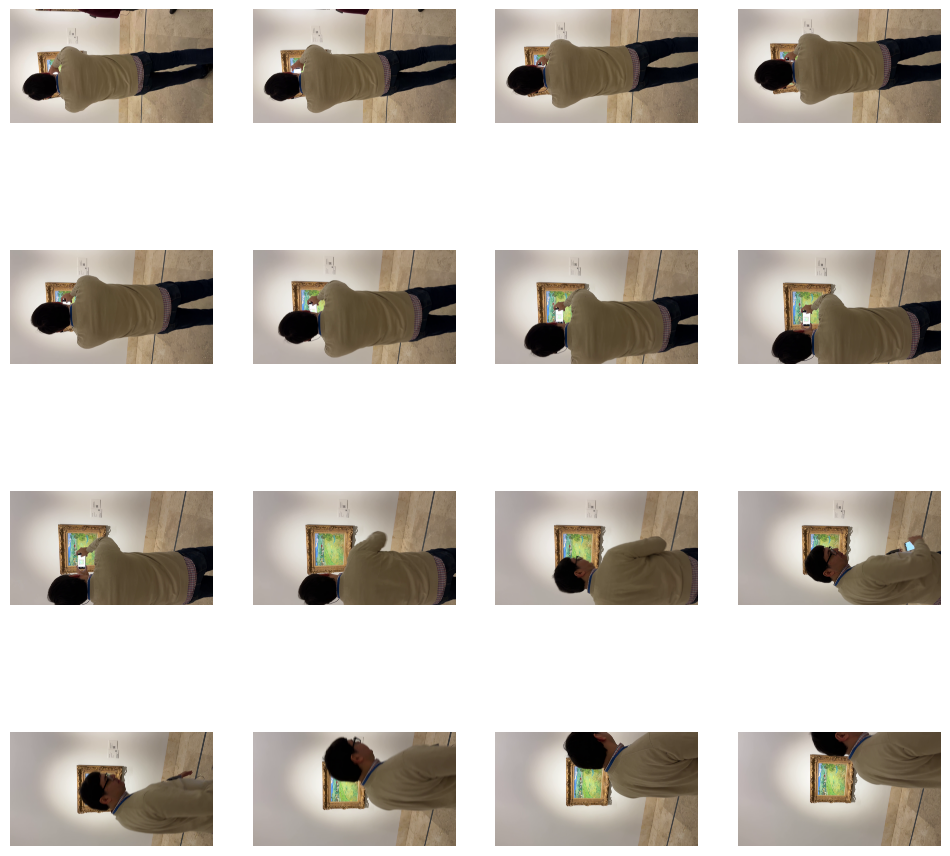

In [5]:
sv.plot_images_grid(frames[:16], grid_size=(4, 4))

## Visual prompt for video processiong

In [ ]:
import base64
import cv2

def encode_numpy_image(img):
    success, encoded_image = cv2.imencode('.jpg', img)
    if not success:
        raise ValueError("Could not encode image to JPEG format.")

    base64_bytes = base64.b64encode(encoded_image)
    base64_str = base64_bytes.decode('utf-8')

    return f"data:image/jpg;base64,{base64_str}"

In [ ]:
IS_COLAB = True
SOURCE_VIDEO_PATH = "croissant-1280x720.mp4"
TARGET_VIDEO_PATH = "croissant-1280x720-result.mp4"
NAMES = ["croissant"]

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

if IS_COLAB:
    from google.colab import output
    output.enable_custom_widget_manager()

from jupyter_bbox_widget import BBoxWidget

widget = BBoxWidget(classes=NAMES)
widget.image = encode_numpy_image(frame)
widget

BBoxWidget(classes=['croissant'], colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#…

In [ ]:
widget.bboxes

[{'x': 529, 'y': 242, 'width': 531, 'height': 225, 'label': 'croissant'}]

In [ ]:
import numpy as np

default_box = [
    {'x': 530, 'y': 246, 'width': 517, 'height': 221, 'label': 'croissant'}
]

boxes = widget.bboxes if widget.bboxes else default_box
bboxes = np.array([
    [
        box['x'],
        box['y'],
        box['x'] + box['width'],
        box['y'] + box['height']
    ] for box in boxes
], dtype=np.float64)

cls = np.array([NAMES.index(box['label']) for box in boxes], dtype=np.int32)

In [ ]:
%%time

from ultralytics import YOLOE
from ultralytics.models.yolo.yoloe.predict_vp import YOLOEVPSegPredictor

model = YOLOE("yoloe-v8l-seg.pt").cuda()
prompts = dict(bboxes=bboxes, cls=cls)

model.predict(frame, prompts=prompts, predictor=YOLOEVPSegPredictor, return_vpe=True)
model.set_classes(NAMES, model.predictor.vpe)
model.predictor = None

video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

# visualize video frames sample in notebook
frames = []
frame_interval = 10

with sv.VideoSink(TARGET_VIDEO_PATH, video_info) as sink:
    for index, frame in enumerate(tqdm(frame_generator)):

        results = model.predict(frame, verbose=False)
        detections = sv.Detections.from_ultralytics(results[0])

        annotated_image = frame.copy()
        annotated_image = sv.ColorAnnotator().annotate(scene=annotated_image, detections=detections)
        annotated_image = sv.BoxAnnotator().annotate(scene=annotated_image, detections=detections)
        annotated_image = sv.LabelAnnotator().annotate(scene=annotated_image, detections=detections)

        sink.write_frame(annotated_image)

        # visualize video frames sample in notebook
        if index % frame_interval == 0:
            frames.append(annotated_image)


0: 640x640 1 object0, 142.6ms
Speed: 9.2ms preprocess, 142.6ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


335it [00:22, 15.17it/s]

CPU times: user 24.2 s, sys: 223 ms, total: 24.4 s
Wall time: 22.6 s


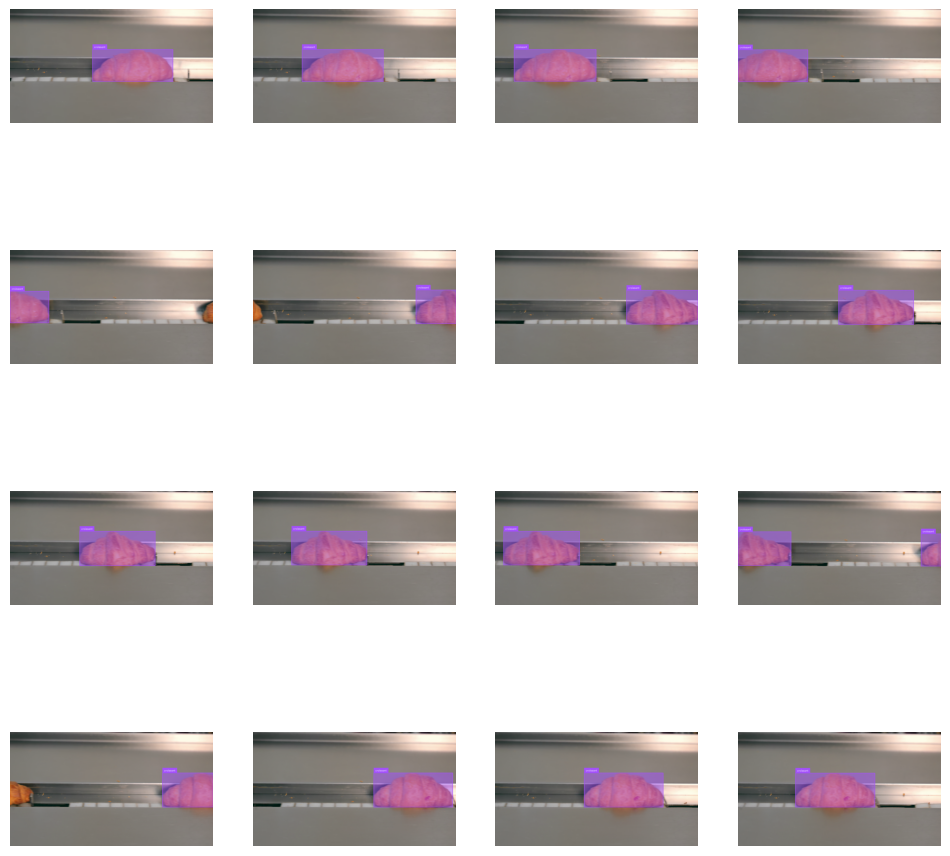

In [ ]:
sv.plot_images_grid(frames[:16], grid_size=(4, 4))

<div align="center">
  <p>
    Looking for more tutorials or have questions?
    Check out our <a href="https://github.com/roboflow/notebooks">GitHub repo</a> for more notebooks,
    or visit our <a href="https://discord.gg/GbfgXGJ8Bk">discord</a>.
  </p>
  
  <p>
    <strong>If you found this helpful, please consider giving us a ⭐
    <a href="https://github.com/roboflow/notebooks">on GitHub</a>!</strong>
  </p>

</div>